# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


### Change directory

In [5]:
import os
os.chdir('/content/drive/MyDrive/Dec 6th Lab')

### Load the training data from train.csv file

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Dec 6th Lab/train_labels.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335


### Print the shape of the train dataset

In [7]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [8]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [9]:
import csv
with open('/content/drive/MyDrive/Dec 6th Lab/train_labels.csv','r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
  spamreader = csv.reader(csvfile, delimiter=',')
  csvfile.seek(0)
  next(spamreader, None)
  for i,row in enumerate(spamreader):
      #print(row)
      for j, r in enumerate(row): # Parse row with seven entities
          #print(i)
          if((j!= 0) & (j!=3)):
              row[j] = int(r)
          
      #print(row)      
      path, width, height, class_, xmin, ymin, xmax, ymax = row
      paths.append(path)
      #print(i)
      coords[i,0] = xmin * IMAGE_SIZE / width
      coords[i,1] = ymin * IMAGE_SIZE / height
      coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
      coords[i,3] = ymax * IMAGE_SIZE / height

In [16]:
paths[0]

'raccoon-17.jpg'

In [12]:
coords[0]

array([46.94980695, 39.58762887, 82.53281853, 77.8556701 ])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [17]:
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open('images/images/'+ f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [18]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [34]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
import tensorflow as tf

In [22]:
ALPHA = 1

In [26]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [36]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [37]:
model.compile(optimizer='adam',loss='mse',metrics=IoU)
model.fit(batch_images,coords,batch_size=32,epochs=30,verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 2s 298ms/step - loss: 4019.2100 - IoU: 0.0807
Epoch 2/30
6/6 [==============================] - 2s 295ms/step - loss: 769.0867 - IoU: 0.4261
Epoch 3/30
6/6 [==============================] - 2s 295ms/step - loss: 455.6490 - IoU: 0.5827
Epoch 4/30
6/6 [=========================

### Pick a test image from the given data

In [89]:
test_image = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
orig_img= Image.open('/content/racoon.jpg')

In [90]:
image_height, image_width= img.size
image_height,image_width

(128, 128)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [91]:
img_resize = orig_img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
img = img_resize.convert('RGB')
test_image[0] = preprocess_input(np.array(img, dtype=np.float32))

In [92]:
test_image[0].shape

(128, 128, 3)

In [93]:
test_img = test_image[0].reshape(1,128,128,3)
region = list(model.predict(test_img))[0]
region

array([ 16.119175,   8.271683, 109.72285 , 122.38336 ], dtype=float32)

In [94]:
test_img.shape

(1, 128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

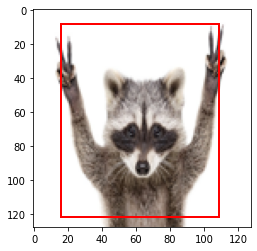

In [95]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_resize)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()